# Projeto Wine Scrapper

> Um sistema para extração de dados e análise em sites de comércio e avaliação de vinhos

***


## Parte 1 - Web scrapper do site da Wine.com.br

### 1.1. Testes com páginas individuais

In [1]:
import requests
page = requests.get("https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html")

from bs4 import BeautifulSoup as bs

soup = bs(page.content, 'html.parser')


product = soup.find('article', class_='ProductDisplay')

ProductName = product.find('div', class_='ProductDisplay-name')
product_name_a = ProductName.find('a')

print(product_name_a['title'])
print("https://wine.com.br" + product_name_a['href'])

country = product.find(class_="Country")
print(country.span.text)

wine_type = product.find(class_="ProductDisplay-type")
print(wine_type.span.text)

wine_description = product.find(class_="ProductDisplay-descriptionText")
print(wine_description.text)
      
# print(product_name_a.prettify())

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016
https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Chile
tinto
Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias


In [2]:
# Buscando Notas e numero de avaliações
import re

wine_rating = product.find('div',class_='Rating')
wine_evaluation_tag = wine_rating.find('evaluation-tag')
if (wine_evaluation_tag):
    wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
    wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
else:
    wine_evaluation = None
    wine_rating_count = 0

print(str(wine_rating))
print(wine_evaluation)
print(wine_rating_count)

<div class="Rating">
<div class="Rating-stars">
<div class="vue-evaluation-tag">
<evaluation-tag :evaluation="4.0"></evaluation-tag>
</div>
</div>
<a class="Rating-count" href="/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html#Comments">(7)</a>
</div>
4.0
7


In [3]:
# Buscando Preço

price_box = product.find(class_="ProductDisplay-priceBox")

lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
print(lowest_price)
print(full_price)

discount = 1-float(lowest_price)/float(full_price)
print(discount)

145.76
180.90
0.1942509673852958


In [4]:
# Buscando Número de Páginas

pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
int(pages_list[len(pages_list)-1].a.text)

47

In [5]:
# Juntando tudo para processar a lista de uma só página

wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

for wine_item in wine_list:
    wine = wine_item.find('article', class_='ProductDisplay')

    wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
    wine_link = "https://wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
    wine_country = wine.find(class_="Country").span.text
    wine_type = wine.find(class_="ProductDisplay-type").span.text
    wine_description = wine.find(class_="ProductDisplay-descriptionText").text
    
    wine_rating = wine.find('div',class_='Rating')
    wine_evaluation_tag = wine_rating.find('evaluation-tag')
    if (wine_evaluation_tag):
        wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
        wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
    else:
        wine_evaluation = None
        wine_rating_count = 0
    
    price_box = wine.find(class_="ProductDisplay-priceBox")

    lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
    full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
    discount = 1-float(lowest_price)/float(full_price)
    
    
    print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_description, ";", wine_link)

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016 ; 4.0 ; 7 ; Chile ; tinto ; 145.76 ; 180.90 ; 0.1942509673852958 ; Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias ; https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Finca La Chamiza Martín Alsina Malbec 2014 ; None ; 0 ; Argentina ; tinto ; 292.82 ; 495.90 ; 0.4095180479935471 ; Frutado, amadeirado, corpo de médio para encorpado, taninos presentes, acidez agradável ; https://wine.com.br/vinhos/finca-la-chamiza-martin-alsina-malbec-2014/prod20028.html
Domaine L'Ostal Cazes Grand Vin 2015 ; None ; 0 ; França ; tinto ; 258.71 ; 335.90 ; 0.22980053587377192 ; Encorpado, boa acidez, taninos macios ; https://wine.com.br/vinhos/domaine-l-ostal-cazes-grand-vin-2015/prod20143.html
Echo de Lynch-Bages A.O.C. Pauillac 2014 ; None ; 0 ; França ; tinto ; 721.06 ; 1056.90 ; 0.3177594852871607 ; Exuberante, encorpado, taninos presentes, boa acidez, 

In [22]:
import requests
from lxml.html import fromstring
from itertools import cycle
import traceback
import timeit

def get_proxies():
    url = 'https://free-proxy-list.net/'
    start = timeit.timeit()
    response = requests.get(url)
    end = timeit.timeit()
    print(end - start)
    parser = fromstring(response.text)
    #print (response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:20]:
        #print(i.xpath('.//td[7][contains(text(),"yes")]'))
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

proxies = get_proxies()
print(proxies)
proxy_pool = cycle(proxies)

url = 'https://httpbin.org/ip'
for i in range(1,11):
    #Get a proxy from the pool
    proxy = next(proxy_pool)
    print("Request #%d"%i)
    try:
        start = timeit.timeit()
        response = requests.get(url,proxies={"http": proxy, "https": proxy})
        end = timeit.timeit()
        print (end - start)
        print(response.json())
    except:
        #Most free proxies will often get connection errors. You will have retry the entire request using another proxy to work. 
        #We will just skip retries as its beyond the scope of this tutorial and we are only downloading a single url 
        print("Skipping. Connnection error")

-0.0018271599992658594
{'103.83.116.210:55443', '109.239.243.211:23500', '123.195.152.139:32287', '194.8.146.167:50510', '27.255.13.134:49328'}
Request #1
-0.0012395980002111173
{'origin': '103.15.240.89'}
Request #2
Skipping. Connnection error
Request #3
Skipping. Connnection error
Request #4
Skipping. Connnection error
Request #5
Skipping. Connnection error
Request #6
Skipping. Connnection error
Request #7
0.0003484030003164662
{'origin': '109.239.243.211'}
Request #8
Skipping. Connnection error
Request #9
-0.0026197279994448763
{'origin': '194.8.146.167'}
Request #10
Skipping. Connnection error


### 1.2. Sistema Winescrapper

In [1]:
# Webscrapper do Site da Wine
# Cabeçalhos e Imports

from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time

URL_RAIZ="https://www.wine.com.br"
URL_BASE = URL_RAIZ+"/vinhos/tinto/cVINHOS-atTIPO_TINTO-p{0}.html"


HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/78.0.3904.87 Safari/537.36'),
    'Connection':'close'
}



In [2]:
# Funções

def get_num_pages(soup):
    
    pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
    num_pages = int(pages_list[len(pages_list)-1].a.text) + 1
    
    return num_pages

def scrape_soup(soup):
    
    list_name=[]
    list_link, list_country, list_type, list_description= [], [], [], []
    list_evaluation, list_rating_count= [], []
    list_lowest_price, list_full_price, list_discount= [], [], []
    
    wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

    for wine_item in wine_list:
        
        try:
            wine = wine_item.find('article', class_='ProductDisplay')

            wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
            wine_link = "wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
            wine_country = wine.find(class_="Country").span.text
            wine_type = wine.find(class_="ProductDisplay-type").span.text
            wine_description = wine.find(class_="ProductDisplay-descriptionText").text
        
            wine_rating = wine.find('div',class_='Rating')
            wine_evaluation_tag = wine_rating.find('evaluation-tag')
            if (wine_evaluation_tag):
                wine_evaluation = float(re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group())
                wine_rating_count = float(re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group())
            else:
                wine_evaluation = 0
                wine_rating_count = 0
    
        
            price_box = wine.find(class_="ProductDisplay-priceBox")

            lowest_price = float(price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text)
            full_price = float(price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text)
            discount = 1-float(lowest_price)/float(full_price)
        except:
            if wine_name:
                print('skip incomplete item:', wine_name)
                continue
            else:
                print("skip incomplete item: no name")
                continue
        
        list_name.append(wine_name)
        list_link.append(wine_link)
        list_country.append(wine_country)
        list_type.append(wine_type)
        list_description.append(wine_description)
        
        list_evaluation.append(wine_evaluation)
        list_rating_count.append(wine_rating_count)

        list_lowest_price.append(lowest_price)
        list_full_price.append(full_price)
        list_discount.append(discount)
        
        ###print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_link)
    
    df = pd.DataFrame({
        'wine_name': list_name,
        'link': list_link,
        'country': list_country,
        'type': list_type,
        'description': list_description,
        'evaluation': list_evaluation,
        'rating_count': list_rating_count,
        'lowest_price': list_lowest_price,
        'full_price': list_full_price,
        'discount': list_discount
    })
    
    return df
        
    

def get_soup(page_url, retry_count=0):
    
    session= requests.Session()
    session.trust_env = False
    
    print("Iniciando session_get")
    
    try:
        response = session.get(page_url, headers=HEADERS)
        print("\nScraping page:",page_url," = ", response)
        soup = bs(response.content, 'html.parser')
        return soup
    except:
        print("Get falhou")
        retry_count += 1
        if retry_count <= 3:
            print("retry get")
            session = requests.Session()
            get_soup(page_url, retry_count)
        else:
            raise
    
    


    


In [3]:
# Módulo Principal - Processamento do Site

pages_to_scrape = 4

current_page = 1

wine_df = pd.DataFrame(columns=['wine_name','link','country','type','description','evaluation','rating_count','lowest_price','full_price','discount'])

while (current_page != pages_to_scrape):
    
    print("Iniciando get_soup pagina", current_page)
    
    wine_soup = get_soup(URL_BASE.format(current_page))
    
    if current_page == 1:
        pages_to_scrape = get_num_pages(wine_soup)
    
    new_df = scrape_soup(wine_soup)
    wine_df= wine_df.append(new_df, ignore_index=True)
    
    ###print(current_page)
    
    time.sleep(10)
    current_page += 1
    
print("Scrape finished.")
wine_df



Iniciando get_soup pagina 1
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html  =  <Response [200]>
skip incomplete item: WineBox Pinhal da Torre
skip incomplete item: WineBox Mosaiko - 3 garrafas
skip incomplete item: WineBox Vik 2012 - 2 garrafas
skip incomplete item: WineBox Aphotic Red - 2 Garrafas
skip incomplete item: Winebox Especial Edna Valley Central Coast Pinot Noir 2017
skip incomplete item: WineBox Canepa Reserva Famiglia Syrah 2018
skip incomplete item: WineBox Queridinhos
skip incomplete item: WineBox Notáveis
skip incomplete item: Winebox Especial Velho Mundo
Iniciando get_soup pagina 2
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p2.html  =  <Response [200]>
skip incomplete item: Winebox Suolo Rosso D.O.P. Primitivo di Manduria 2016
skip incomplete item: WineBox Mãe cineasta
skip incomplete item: WineBox Diferentes Terroirs
skip incomplete item: WineBox Quatro Contin

Iniciando get_soup pagina 40
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p40.html  =  <Response [200]>
skip incomplete item: WineBox Lievland Vineyards - 3 garrafas
skip incomplete item: WineBox Portas da Herdade - 4 garrafas
Iniciando get_soup pagina 41
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p41.html  =  <Response [200]>
skip incomplete item: WineBox Root: 1 - 4 garrafas
Scrape finished.


,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
0,Château des Places A.O.C. Graves 2016,wine.com.br/vinhos/chateau-des-places-a-o-c-gr...,França,tinto,"Suculento, taninos vivos e final persistente",0.0,0.0,233.90,233.9,0.000000
1,Quinta de São João Cuvée RB Tinto 2017,wine.com.br/vinhos/quinta-de-sao-joao-cuvee-rb...,Portugal,tinto,"Médio corpo, fresco, taninos sedosos, frutado",4.0,100.0,46.94,73.9,0.364817
2,Ernst Loosen Pfalz Edition Dornfelder 2018,wine.com.br/vinhos/ernst-loosen-pfalz-edition-...,Alemanha,tinto,"Frutado, leve, acidez agradável, taninos macios",5.0,2.0,70.47,117.9,0.402290
3,Partridge Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/partridge-reserva-cabernet-...,Argentina,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.0,44.0,56.35,79.9,0.294743
4,VIK 2012,wine.com.br/vinhos/vik-2012/prod21001.html,Chile,tinto,"Potente, taninos firmes, boa acidez, complexo,...",5.0,10.0,941.06,1370.9,0.313546
...,...,...,...,...,...,...,...,...,...,...
312,Lidio Carraro Agnus Cabernet Sauvignon 2018,wine.com.br/vinhos/lidio-carraro-agnus-caberne...,Brasil,tinto,"Médio corpo, taninos presentes, fresco, frutad...",4.5,5.0,88.12,114.9,0.233072
313,Mosaiko 2015,wine.com.br/vinhos/mosaiko-2015/prod23118.html,Chile,tinto,"Suculento, corpo médio e taninos macios",4.0,70.0,70.47,80.9,0.128925
314,Amara Pinotage 2018.,wine.com.br/vinhos/amara-pinotage-2018-/prod23...,África do Sul,tinto,"Encorpado,taninos macios e final persistente",4.0,109.0,74.00,122.9,0.397884
315,Passión Arte D.O. Jumilla Monastrell 2018,wine.com.br/vinhos/passion-arte-d-o-jumilla-mo...,Espanha,tinto,"Médio corpo, acidez agradável, taninos macios",3.0,11.0,45.76,65.9,0.305615


In [4]:
# Análise do dados

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2) & (wine_df.lowest_price < 66.20)]
wine_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
9,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,447.0,64.90,64.90,0.000000
119,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,436.0,54.67,54.67,0.000000
168,Maycas Del Limarí Reserva Sumaq Syrah Tinto 2017,wine.com.br/vinhos/maycas-del-limari-reserva-s...,Chile,tinto,"Médio corpo, boa acidez, taninos macios",4.5,41.0,64.59,99.90,0.353453
269,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,wine.com.br/vinhos/ropiteau-freres-les-plants-...,França,tinto,"Corpo de leve para médio, fresco, taninos deli...",4.5,69.0,58.71,79.90,0.265207
292,Partridge Flying Malbec 2019,wine.com.br/vinhos/partridge-flying-malbec-201...,Argentina,tinto,"Corpo de leve para médio, frutado, acidez agra...",4.5,49.0,39.88,59.90,0.334224
301,Root: 1 Reserva Heritage Red 2018,wine.com.br/vinhos/root-1-reserva-heritage-red...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável",4.5,101.0,45.76,64.90,0.294915
306,Corello D.O.C. Sicília Nero d'Avola 2017,wine.com.br/vinhos/corello-d-o-c-sicilia-nero-...,Itália,tinto,"Corpo de leve para médio, fresco, taninos sedosos",4.5,84.0,50.47,75.90,0.335046
309,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,537.0,41.06,54.90,0.252095


In [5]:
wine_exotic = wine_df.loc[~wine_df.country.isin(['Chile','França','Espanha','Argentina','Itália','Portugal','Brasil','Estados Unidos','Uruguai'])]
wine_exotic.loc[wine_exotic.country == 'China']

#wine_exotic.iloc[2].link

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
67,Changyu Reserve Noble Dragon Red 2016,wine.com.br/vinhos/changyu-reserve-noble-drago...,China,tinto,"Encorpado, frutado, taninos firmes.",3.5,90.0,44.59,76.9,0.420156
83,Chateau Moser XV Cabernet Sauvignon 2017,wine.com.br/vinhos/chateau-moser-xv-cabernet-s...,China,tinto,"Saboroso, encorpado, boa acidez",3.5,35.0,56.35,85.9,0.344005


In [6]:
# Exemplo do uso de Describe
wine_df.lowest_price.describe()

count      317.000000
mean       519.398423
std       1621.056191
min         31.650000
25%         65.760000
50%         99.880000
75%        223.900000
max      14598.710000
Name: lowest_price, dtype: float64

In [7]:
# Mais um exemplo de Describe

wine_df.loc[wine_df.evaluation > 0].describe()

,evaluation,rating_count,lowest_price,full_price,discount
count,228.000000,228.000000,228.000000,228.000000,228.000000
mean,4.024123,50.140351,229.518904,350.963289,0.289277
std,0.619497,130.690803,825.479979,1326.317514,0.157218
min,1.000000,1.000000,31.650000,43.900000,0.000000
25%,4.000000,4.000000,60.765000,93.650000,0.229453
50%,4.000000,17.000000,82.240000,120.400000,0.330065
75%,4.500000,44.000000,141.900000,203.150000,0.405872
max,5.000000,1420.000000,9303.410000,14794.900000,0.559382


In [8]:
#Exemplo de funções de sumário

print(wine_df.country.describe())
print(wine_df.rating_count.mean())
print(wine_df.country.unique())

count        317
unique        15
top       França
freq          75
Name: country, dtype: object
36.063091482649845
['França' 'Portugal' 'Alemanha' 'Argentina' 'Chile' 'Líbano'
 'África do Sul' 'Espanha' 'Itália' 'Estados Unidos' 'Uruguai' 'China'
 'Áustria' 'Austrália' 'Brasil']


In [9]:
# Exemplo de groupby
wine_df.groupby('country').lowest_price.min()

country
Alemanha           70.47
Argentina          39.88
Austrália          70.47
Brasil             88.12
Chile              31.65
China              44.59
Espanha            35.18
Estados Unidos     58.71
França             38.71
Itália             43.41
Líbano            126.94
Portugal           43.41
Uruguai            50.47
África do Sul      36.35
Áustria            99.88
Name: lowest_price, dtype: float64

In [10]:
# Exemplo de min
wine_deals.groupby('country').lowest_price.min()

country
Argentina    39.88
Chile        45.76
Espanha      41.06
França       54.67
Itália       50.47
Name: lowest_price, dtype: float64

In [11]:
# Exemplo de Apply
wine_df.groupby(['country','type']).apply(lambda df: df.loc[df.rating_count.idxmax()])

,,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
country,type,,,,,,,,,,
Alemanha,tinto,Ernst Loosen Winemakers Select Pfalz Edition P...,wine.com.br/vinhos/ernst-loosen-winemakers-sel...,Alemanha,tinto,"Leve, acidez presente, taninos sedosos",4.0,20.0,77.53,119.90,0.353378
Argentina,tinto,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,341.0,117.53,179.90,0.346693
Austrália,tinto,Oxford Landing Cabernet Shiraz 2016,wine.com.br/vinhos/oxford-landing-cabernet-shi...,Austrália,tinto,"Corpo de leve para médio, boa acidez, taninos ...",3.5,9.0,70.47,120.90,0.417122
Brasil,tinto,Lidio Carraro Agnus Cabernet Sauvignon 2018,wine.com.br/vinhos/lidio-carraro-agnus-caberne...,Brasil,tinto,"Médio corpo, taninos presentes, fresco, frutad...",4.5,5.0,88.12,114.90,0.233072
Chile,tinto,Undurraga Talagante Reserva Pinot Noir 2018,wine.com.br/vinhos/undurraga-talagante-reserva...,Chile,tinto,"Fresco, jovem, corpo médio e com bela acidez",4.0,521.0,58.90,58.90,0.000000
China,tinto,Changyu Reserve Noble Dragon Red 2016,wine.com.br/vinhos/changyu-reserve-noble-drago...,China,tinto,"Encorpado, frutado, taninos firmes.",3.5,90.0,44.59,76.90,0.420156
Espanha,tinto,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,537.0,41.06,54.90,0.252095
Estados Unidos,tinto,Bear Flag Red Blend 2018,wine.com.br/vinhos/bear-flag-red-blend-2018/pr...,Estados Unidos,tinto,"Encorpado, macio, saboroso e com final persist...",4.0,1420.0,58.71,68.90,0.147896
França,tinto,Café du Midi IGP Pays dOc Cabernet Sauvignon 2019,wine.com.br/vinhos/cafe-du-midi-igp-pays-doc-c...,França,tinto,"Bom corpo, boa acidez e final agradável",4.0,551.0,58.75,58.75,0.000000


In [12]:
# Exemplo de sort

sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])
sorted_wines

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
292,Partridge Flying Malbec 2019,wine.com.br/vinhos/partridge-flying-malbec-201...,Argentina,tinto,"Corpo de leve para médio, frutado, acidez agra...",4.5,49.0,39.88,59.90,0.334224
309,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,537.0,41.06,54.90,0.252095
301,Root: 1 Reserva Heritage Red 2018,wine.com.br/vinhos/root-1-reserva-heritage-red...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável",4.5,101.0,45.76,64.90,0.294915
306,Corello D.O.C. Sicília Nero d'Avola 2017,wine.com.br/vinhos/corello-d-o-c-sicilia-nero-...,Itália,tinto,"Corpo de leve para médio, fresco, taninos sedosos",4.5,84.0,50.47,75.90,0.335046
119,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,436.0,54.67,54.67,0.000000
269,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,wine.com.br/vinhos/ropiteau-freres-les-plants-...,França,tinto,"Corpo de leve para médio, fresco, taninos deli...",4.5,69.0,58.71,79.90,0.265207
168,Maycas Del Limarí Reserva Sumaq Syrah Tinto 2017,wine.com.br/vinhos/maycas-del-limari-reserva-s...,Chile,tinto,"Médio corpo, boa acidez, taninos macios",4.5,41.0,64.59,99.90,0.353453
9,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,447.0,64.90,64.90,0.000000


In [13]:
# Exemplo de iterator em DataFrame

for index, row in sorted_wines.iterrows():
    print(row.wine_name, "\t", row.link)



Partridge Flying Malbec 2019 	 wine.com.br/vinhos/partridge-flying-malbec-2019/prod23315.html
Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018 	 wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html
Root: 1 Reserva Heritage Red 2018 	 wine.com.br/vinhos/root-1-reserva-heritage-red-2018/prod22767.html
Corello D.O.C. Sicília Nero d'Avola 2017 	 wine.com.br/vinhos/corello-d-o-c-sicilia-nero-d-avola-2017/prod22056.html
Gérard Bertrand Narbo Martius Réserve Blend 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-reserve-blend-2018/prod23409.html
Ropiteau Frères Les Plants Nobles Pinot Noir 2017 	 wine.com.br/vinhos/ropiteau-freres-les-plants-nobles-pinot-noir-2017/prod22808.html
Maycas Del Limarí Reserva Sumaq Syrah Tinto 2017 	 wine.com.br/vinhos/maycas-del-limari-reserva-sumaq-syrah-tinto-2017/prod19861.html
Gérard Bertrand Narbo Martius Cabernet Sauvignon 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-cabernet-sauvignon-2018/prod23408.html


### 1.3. Análise Descritiva - Wine


In [14]:
# Gráficos

import matplotlib.pyplot as plt

#wine_df.boxplot(column=wine_df.groupby('country'))
wine_df.groupby('country')['lowest_price'].describe()


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Alemanha,2.0,74.000000,4.992174,70.47,72.2350,74.000,75.7650,77.53
Argentina,35.0,126.839429,89.482410,39.88,70.4700,99.880,141.9000,445.76
Austrália,2.0,70.470000,0.000000,70.47,70.4700,70.470,70.4700,70.47
Brasil,1.0,88.120000,NaN,88.12,88.1200,88.120,88.1200,88.12
Chile,49.0,138.207755,181.713552,31.65,54.0000,74.000,134.0000,941.06
China,2.0,50.470000,8.315576,44.59,47.5300,50.470,53.4100,56.35
Espanha,51.0,112.979216,104.556949,35.18,60.4700,78.710,122.3900,659.88
Estados Unidos,29.0,632.877931,1684.670382,58.71,118.3400,141.060,206.9000,8938.71
França,75.0,1552.167200,2929.323232,38.71,86.9400,233.900,1464.5900,14598.71


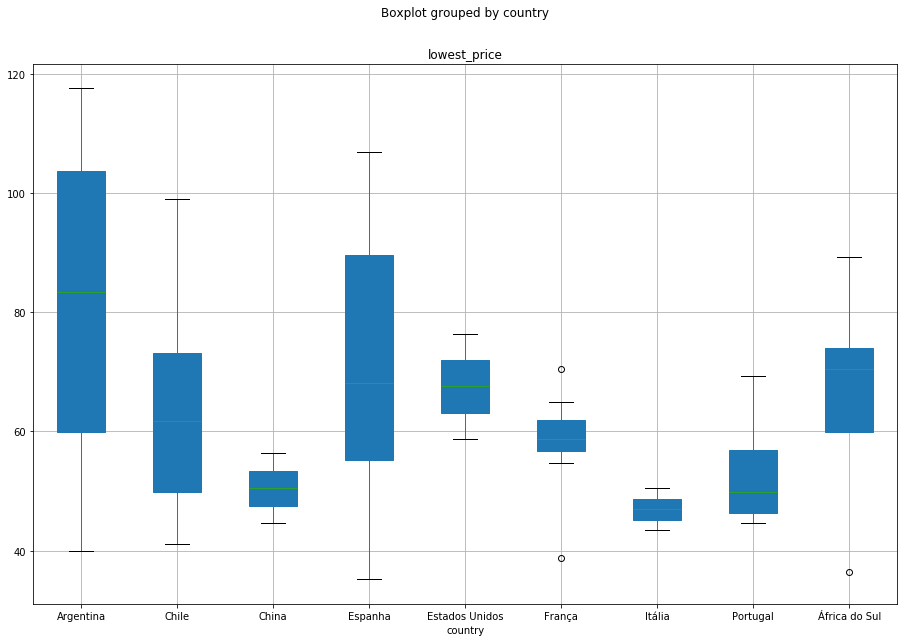

In [15]:
wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

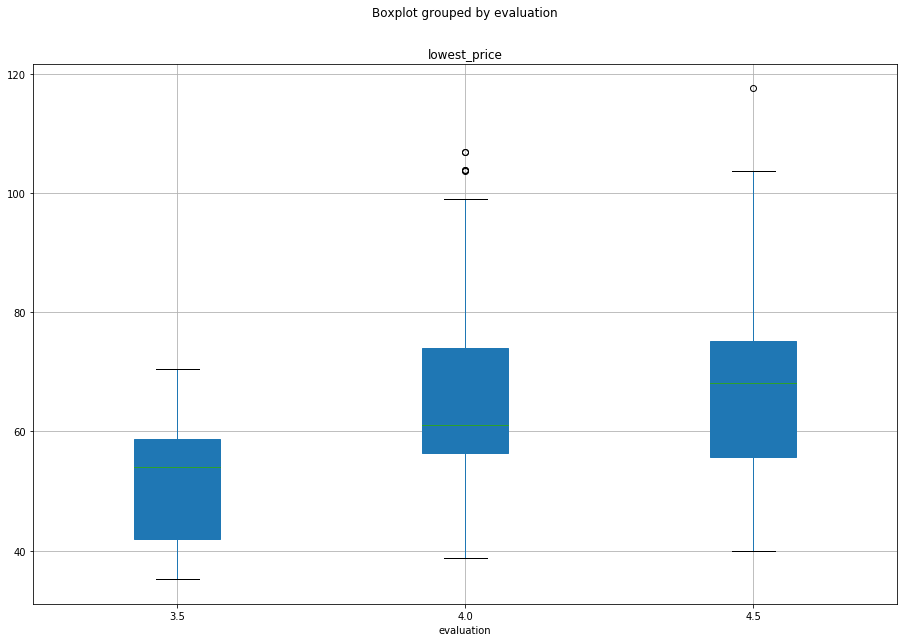

In [16]:
wine_plot = wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 1000.0) & (wine_df.rating_count > 34.0)]
wine_plot.boxplot(by='evaluation',column=['lowest_price'], figsize=(15,10), patch_artist=True)

In [17]:
wine_df.evaluation.corr(wine_df.lowest_price)

-0.26142898352958915

## Parte 2 - Busca no Vivino

### 2.1. Testes Individuais

#### URL Encoding para buscar no Vivino


In [18]:
import urllib.parse

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2)]
sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])

#row = next(sorted_wines.iterrows())[1]
#Pegando o segundo da lista
row = sorted_wines.iloc[0]

query_url = urllib.parse.quote(row.wine_name)
row.wine_name

#for index, row in sorted_wines.iterrows():
#    query_url = urllib.parse.quote(row.wine_name)
#    print(query_url.replace("%20","+"), "\t", 'https://'+row.link)

'Partridge Flying Malbec 2019'

In [27]:
new_url = 'https://www.vivino.com/search/wines?q='+query_url.replace("%20","+")
new_url

'https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018'

In [28]:
row.link

'wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html'

#### Busca no Vivino


In [ ]:
vivino_soup = get_soup(new_url)

#print(vivino_soup.body.prettify())

In [ ]:
vivino_search_item = vivino_soup.find('div', class_="wine-card__content")

vivino_name = vivino_search_item.find('span', class_="wine-card__name").text.replace("\n","")
print(vivino_name)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

vivino_price = vivino_search_item.find('div', class_="wine-price")
vivino_price

#### Tentando com Selenium

In [ ]:
from selenium import webdriver

browser = webdriver.Chrome('/Users/giuliano/Documents/dev-python/scrapper/bin/chromedriver')
browser.get(new_url)

vivino_soup_byselenium = bs(browser.page_source,'html.parser')

vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")


In [ ]:
vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
vivino_name = vivino_name_card.text.replace("\n","")
print(vivino_name)

vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
print(vivino_link)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

try:
    vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
    vivino_price = float(vivino_price_txt.replace(",","."))
except:
    vivino_price = None
print(vivino_price)

In [ ]:
browser.close()

### 2.1. Prova de Conceito

> Busca vinhos do dataframe da wine no vivino, acha os dados e cria um novo dataframe.

In [20]:
from selenium import webdriver
from time import perf_counter

VIVINO_SEARCH_URL = 'https://www.vivino.com/search/wines?q='

browser = webdriver.Chrome('C:\\Users\\gmendonc\\Dev\\Scrapper\\winescrapper\\chromedriver_win32\\chromedriver')

reference_df = wine_df

lst_vivino_name, lst_vivino_link, lst_vivino_score, lst_vivino_rating, lst_vivino_price = [], [], [], [], []
lst_original_name = []

for index, row in reference_df.iterrows():
    
    query_url = urllib.parse.quote(row.wine_name)
    new_url = VIVINO_SEARCH_URL+query_url.replace("%20","+")
    
    print("Searching...", new_url)
    
    start_time = perf_counter()
    
    try:
        browser.get(new_url)
        vivino_soup_byselenium = bs(browser.page_source,'html.parser')
        vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")
        vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
        vivino_name = vivino_name_card.text.replace("\n","")
        lst_original_name.append(row.wine_name)
        lst_vivino_name.append(vivino_name)

        vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
        lst_vivino_link.append(vivino_link)

        vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
        try:
            vivino_average_score = float(vivino_average_score_txt.replace(",","."))
        except:
            vivino_average_score = None
        lst_vivino_score.append(vivino_average_score)

        try:
            vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
            vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
        except:
            vivino_rating = None
        lst_vivino_rating.append(vivino_rating)

        try:
            vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
            vivino_price = float(vivino_price_txt.replace(",","."))
        except:
            vivino_price = None
        lst_vivino_price.append(vivino_price)
    
        time.sleep(2)
    except:
        print("Next!")
    
    elapsed_time = perf_counter()-start_time
    print("tempo: ", elapsed_time)
        
    
browser.close()

df = pd.DataFrame({
        'wine_name' : lst_original_name,
        'vivino_name': lst_vivino_name,
        'vivino_link': lst_vivino_link,
        'vivino_score': lst_vivino_score,
        'vivino_rating': lst_vivino_rating,
        'vivino_price': lst_vivino_price,
    })

df
    
    

Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+des+Places+A.O.C.+Graves+2016
tempo:  7.780542456785952
Searching... https://www.vivino.com/search/wines?q=Quinta+de+S%C3%A3o+Jo%C3%A3o+Cuv%C3%A9e+RB+Tinto+2017
tempo:  4.0367906062256225
Searching... https://www.vivino.com/search/wines?q=Ernst+Loosen+Pfalz+Edition+Dornfelder+2018
tempo:  3.812076011919089
Searching... https://www.vivino.com/search/wines?q=Partridge+Reserva+Cabernet+Sauvignon+2018
tempo:  3.915006570858168
Searching... https://www.vivino.com/search/wines?q=VIK+2012
tempo:  3.952002835460007
Searching... https://www.vivino.com/search/wines?q=Canepa+Fin%C3%ADsimo+Gran+Reserva+Carm%C3%A9n%C3%A8re+2018
tempo:  3.3247396817105255
Searching... https://www.vivino.com/search/wines?q=Urmeneta+Cabernet+Sauvignon+2019
tempo:  3.3850716084966734
Searching... https://www.vivino.com/search/wines?q=Chateau+Oumsiyat+Red+Jaspe+2014
tempo:  4.031840948770423
Searching... https://www.vivino.com/search/wines?q=Casillero+del+D

tempo:  2.987145986817268
Searching... https://www.vivino.com/search/wines?q=Changyu+Reserve+Noble+Dragon+Red+2016
tempo:  3.8756543509875883
Searching... https://www.vivino.com/search/wines?q=Apothic+Dark+2016
tempo:  3.322425295688845
Searching... https://www.vivino.com/search/wines?q=Antinori+Pian+delle+Vigne+D.O.C.G.+Brunello+di+Montalcino+2013
tempo:  5.4116110197883245
Searching... https://www.vivino.com/search/wines?q=Passi%C3%B3n+Arte+D.O.+Jumilla%C2%A0Garnacha%C2%A02018
tempo:  3.634545429351874
Searching... https://www.vivino.com/search/wines?q=Partridge+Reserva+Pinot+Noir+2018
tempo:  3.2818449598385087
Searching... https://www.vivino.com/search/wines?q=William+Hill+Central+Coast+Cabernet+Sauvignon+2017
tempo:  3.2101022749316144
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+La+Fleur-P%C3%A9trus+A.O.C.+Pomerol+2006
tempo:  5.638817581019794
Searching... https://www.vivino.com/search/wines?q=Fleur+Du+Cap+Laszlo+2015.
tempo:  3.1761092060564806
Searching... h

tempo:  3.337187118492693
Searching... https://www.vivino.com/search/wines?q=Luigi+Bosca+Terroir+Los+Miradores+Malbec+2017
tempo:  3.4777783206900494
Searching... https://www.vivino.com/search/wines?q=Les+Tours+de+La+Rivi%C3%A8re+A.O.C.+Fronsac+2016
tempo:  4.206553574007103
Searching... https://www.vivino.com/search/wines?q=Carlos+Reynolds+2017
tempo:  3.194827400113354
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+de+La+Rivi%C3%A8re+A.O.C.+Fronsac+2011
tempo:  4.515776258271671
Searching... https://www.vivino.com/search/wines?q=Carpineto+Riserva+D.O.C.G.+Vino+Nobile+di+Montepulciano+2015
tempo:  4.6680531590441205
Searching... https://www.vivino.com/search/wines?q=Carpineto+Riserva+D.O.C.G.+Chianti+Classico+2015
tempo:  6.151754003410133
Searching... https://www.vivino.com/search/wines?q=Altivo+Classic+Mendoza+Cabernet+Sauvignon+2019
tempo:  3.1859582002994102
Searching... https://www.vivino.com/search/wines?q=Montado+Tinto+2018
tempo:  4.06402429685977
Searching...

tempo:  4.0838973137515495
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Haut-Brion+2007
tempo:  4.029879901342156
Searching... https://www.vivino.com/search/wines?q=Apothic+Crush+2016
tempo:  3.1981554923186195
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Margaux+Premier+Grand+Cru+Class%C3%A9+A.O.C.+Margaux+2008
tempo:  4.102210754620501
Searching... https://www.vivino.com/search/wines?q=Teorema+D.O.+Calatayud+Garnacha+2016
tempo:  3.9650450041790464
Searching... https://www.vivino.com/search/wines?q=Lafken+Artisan+Wine+Carm%C3%A9n%C3%A8re+2017
tempo:  4.006507410265385
Searching... https://www.vivino.com/search/wines?q=Calyptra+Prestige+2015
tempo:  2.8970902256846784
Searching... https://www.vivino.com/search/wines?q=La+Veguilla+6+Meses+em+Barrica+2016
tempo:  4.921258366722213
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Haut-Brion+Le+Clarence+de+Haut-Brion+2010
tempo:  3.214107508280904
Searching... https://www.vivino.com/sea

tempo:  3.1795612767155035
Searching... https://www.vivino.com/search/wines?q=Serras+De+Azeit%C3%A3o+Sele%C3%A7%C3%A3o+Do+En%C3%B3logo+Tinto+2018
tempo:  2.915074029722291
Searching... https://www.vivino.com/search/wines?q=Canepa+Nov%C3%ADsimo+Cabernet+Sauvignon+2019
tempo:  2.859860225232296
Searching... https://www.vivino.com/search/wines?q=Cent%27Are+I.G.P.+Terre+Siciliane+Nero+d%27%C3%81vola+2015
tempo:  3.314563603134502
Searching... https://www.vivino.com/search/wines?q=Carpineto+Originale+Vino+Rosso+Italiano
tempo:  6.220121921870486
Searching... https://www.vivino.com/search/wines?q=Norton+Reserva+Syrah+2014
tempo:  3.3370288636424448
Searching... https://www.vivino.com/search/wines?q=Norton+Finca+La+Colonia+Cabernet+Sauvignon+2017
tempo:  2.843078647555558
Searching... https://www.vivino.com/search/wines?q=Villa+Antinori+I.G.T.+Toscana+2016
tempo:  6.9097885365144975
Searching... https://www.vivino.com/search/wines?q=Norton+Porte%C3%B1o+Malbec+2018
tempo:  3.2081251832328235
S

,wine_name,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Château des Places A.O.C. Graves 2016,Château des Places Graves Rouge 2016,www.vivino.com/wines/148983894,3.7,81.0,NaN
1,Quinta de São João Cuvée RB Tinto 2017,Pinhal Da Torre Quinta de São João Cuvée RB Re...,www.vivino.com/wines/155649821,3.5,526.0,42.0
2,Ernst Loosen Pfalz Edition Dornfelder 2018,Ernst Loosen Dornfelder 2018,www.vivino.com/wines/160937862,4.0,10.0,NaN
3,Partridge Reserva Cabernet Sauvignon 2018,Las Perdices Partridge Reserva Cabernet Sauvig...,www.vivino.com/wines/157281635,3.6,210.0,NaN
4,VIK 2012,Viña Vik Winery A 2012,www.vivino.com/wines/92291712,4.2,1169.0,170.0
...,...,...,...,...,...,...
312,Lidio Carraro Agnus Cabernet Sauvignon 2018,Lidio Carraro Agnus Cabernet Sauvignon 2018,www.vivino.com/wines/156598929,3.8,369.0,NaN
313,Mosaiko 2015,Calyptra Mosaiko Cabernet Sauvignon 2015,www.vivino.com/wines/162435670,3.4,275.0,NaN
314,Amara Pinotage 2018.,Marianne Amara Pinotage,www.vivino.com/wines/163013316,3.6,962.0,NaN
315,Passión Arte D.O. Jumilla Monastrell 2018,Pasión Arte Crianza Monastrell,www.vivino.com/wines/20517511,3.6,261.0,NaN


In [21]:
result = pd.merge(reference_df, df, on='wine_name')
result.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
147,Opus One 2013,wine.com.br/vinhos/opus-one-2013/prod19463.html,Estados Unidos,tinto,"Complexo, exuberante, encorpado, boa acidez, t...",0.0,0.0,8938.71,11799.9,0.242476,Opus One Opus One 2013,www.vivino.com/wines/2794433,4.6,5367.0,NaN
205,Château Mouton Rothschild Premier Grand Cru Cl...,wine.com.br/vinhos/chateau-mouton-rothschild-p...,França,tinto,"Suculento, harmonioso, maduro, taninos aveluda...",5.0,1.0,9303.41,14794.9,0.371175,Château Mouton Rothschild Pauillac (Premier Gr...,www.vivino.com/wines/3085744,4.5,867.0,NaN
208,Château Margaux Premier Grand Cru Classé A.O.C...,wine.com.br/vinhos/chateau-margaux-premier-gra...,França,tinto,As frutas dominam o paladar e mesclam-se às no...,0.0,0.0,7223.41,13324.9,0.457901,Château Margaux Château Margaux (Premier Grand...,www.vivino.com/wines/1168755,4.5,665.0,NaN
167,Château de Beaucastel Hommage à Jacques Perrin...,wine.com.br/vinhos/chateau-de-beaucastel-homma...,França,tinto,"Denso, exuberante, estruturado, concentrado, b...",0.0,0.0,6739.88,10789.9,0.375353,Château de Beaucastel Hommage à Jacques Perrin...,www.vivino.com/wines/3896910,4.5,502.0,NaN
183,Château La Fleur-Pétrus 2014,wine.com.br/vinhos/chateau-la-fleur-petrus-201...,França,tinto,"Complexo, elegante, corpo de médio para encorp...",4.0,1.0,3842.24,6564.9,0.414730,Château La Fleur-Pétrus Pomerol 2014,www.vivino.com/wines/4237999,4.5,177.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Altivo Classic Mendoza Cabernet Sauvignon 2019,wine.com.br/vinhos/altivo-classic-mendoza-cabe...,Argentina,tinto,"Médio corpo, frutado, acidez agradável, tanino...",0.0,0.0,44.59,64.9,0.312943,Finca Eugenio Bustos Altivo Classic Cabernet S...,www.vivino.com/wines/160826350,NaN,NaN,NaN
155,Pointer Reserva Carménère 2019,wine.com.br/vinhos/pointer-reserva-carmenere-2...,Chile,tinto,"Corpo de leve para médio, taninos sutis, acide...",0.0,0.0,44.59,59.9,0.255593,Undurraga Pointer Reserva Carménère 2019,www.vivino.com/wines/160184653,NaN,NaN,NaN
47,Miguel Torres Hemisferio Sur Reserva Cabernet ...,wine.com.br/vinhos/miguel-torres-hemisferio-su...,Chile,tinto,"Frutado, corpo entre leve e médio, boa acidez,...",3.5,102.0,41.06,64.9,0.367334,Miguel Torres Hemisferio Sur Reserva Cabernet ...,www.vivino.com/wines/164390049,NaN,NaN,NaN
214,Palafitos de Mar Semi Sweet Carmenére 2018,wine.com.br/vinhos/palafitos-de-mar-semi-sweet...,Chile,tinto,"Taninos suaves e redondos, com boa estrutura e...",4.0,59.0,41.06,49.9,0.177154,Fray Leon Palafitos de Mar Semi Sweet Carmenèr...,www.vivino.com/wines/163488831,NaN,NaN,NaN


In [22]:
result_clean = result.loc[(result.vivino_rating>=100) & (result.lowest_price <= 100.0)]
result_clean.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
5,Canepa Finísimo Gran Reserva Carménère 2018,wine.com.br/vinhos/canepa-finisimo-gran-reserv...,Chile,tinto,"Corpo de médio para encorpado, acidez agradáve...",4.0,18.0,89.29,139.9,0.361758,Canepa Finísimo Gran Reserva Carmenère 2018,www.vivino.com/wines/156859487,4.0,188.0,NaN
101,Protos D.O. Ribera del Duero Tinto Fino 2017,wine.com.br/vinhos/protos-d-o-ribera-del-duero...,Espanha,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.0,18.0,84.59,151.9,0.443120,Protos 12 Meses en Barrica Tinto Fino 2017,www.vivino.com/wines/152152910,4.0,245.0,82.0
66,Pérez Cruz Single Vineyard La Higuera Block 2017,wine.com.br/vinhos/perez-cruz-single-vineyard-...,Chile,tinto,"Corpo de médio para encorpado, taninos present...",4.0,43.0,74.00,99.9,0.259259,Perez Cruz La Higuera Block Single Vineyard 2017,www.vivino.com/wines/156052147,3.9,371.0,NaN
77,Pérez Cruz Winemakers Selection 2017,wine.com.br/vinhos/perez-cruz-winemakers-selec...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,32.0,74.00,99.9,0.259259,Perez Cruz Winemaker's Selection 2017,www.vivino.com/wines/152443541,3.9,271.0,NaN
68,Apothic Dark 2016,wine.com.br/vinhos/apothic-dark-2016/prod22617...,Estados Unidos,tinto,"Corpo de médio para encorpado, acidez agradáve...",4.5,23.0,99.88,141.9,0.296124,Apothic Dark (Red Blend) 2016,www.vivino.com/wines/86701622,3.8,2833.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Urmeneta Cabernet Sauvignon 2019,wine.com.br/vinhos/urmeneta-cabernet-sauvignon...,Chile,tinto,"Corpo de leve para médio, acidez agradável, ta...",4.0,28.0,46.94,49.9,0.059319,Urmeneta Cabernet Sauvignon 2019,www.vivino.com/wines/160182987,3.3,142.0,42.9
248,Portas da Herdade Tinto 2018,wine.com.br/vinhos/portas-da-herdade-tinto-201...,Portugal,tinto,"Frutado, bom corpo, taninos macios, fresco",4.0,104.0,44.59,64.9,0.312943,Portas da Herdade Tinto 2018,www.vivino.com/wines/156859768,3.3,201.0,NaN
35,Beaupont,wine.com.br/vinhos/beaupont/prod22980.html,França,tinto,"Corpo médio, frutado e taninos macios",4.0,155.0,38.71,53.9,0.281818,Benoit Valérie Calvet Collection Beaupont,www.vivino.com/wines/162640361,3.3,364.0,NaN
203,Dalera,wine.com.br/vinhos/dalera/prod23114.html,Espanha,tinto,"Frutado, saboroso, taninos macios",3.5,79.0,35.18,49.9,0.294990,Benoit Valérie Calvet Daléra Colección,www.vivino.com/wines/162260411,3.2,400.0,NaN


In [23]:
result.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,317.000000,317.000000,317.000000,317.000000,317.000000,276.000000,276.000000,74.000000
mean,2.894322,36.063091,519.398423,806.910473,0.296104,3.724275,730.322464,149.213108
std,1.885747,113.043494,1621.056191,2508.076710,0.145124,0.312220,1224.642268,151.091657
min,0.000000,0.000000,31.650000,43.900000,0.000000,2.800000,10.000000,33.000000
25%,0.000000,0.000000,65.760000,99.900000,0.235795,3.500000,98.000000,60.150000
50%,4.000000,5.000000,99.880000,141.900000,0.324707,3.700000,300.500000,99.000000
75%,4.000000,27.000000,223.900000,298.900000,0.403626,3.900000,722.000000,169.500000
max,5.000000,1420.000000,14598.710000,19271.900000,0.568600,4.600000,8749.000000,836.000000


In [24]:
best_deals = result.loc[(result.vivino_rating >= result.vivino_rating.median()) & (result.vivino_score >= result.vivino_score.mean()) & (result.lowest_price <= result.lowest_price.median())]
best_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
66,Pérez Cruz Single Vineyard La Higuera Block 2017,wine.com.br/vinhos/perez-cruz-single-vineyard-...,Chile,tinto,"Corpo de médio para encorpado, taninos present...",4.0,43.0,74.00,99.9,0.259259,Perez Cruz La Higuera Block Single Vineyard 2017,www.vivino.com/wines/156052147,3.9,371.0,NaN
68,Apothic Dark 2016,wine.com.br/vinhos/apothic-dark-2016/prod22617...,Estados Unidos,tinto,"Corpo de médio para encorpado, acidez agradáve...",4.5,23.0,99.88,141.9,0.296124,Apothic Dark (Red Blend) 2016,www.vivino.com/wines/86701622,3.8,2833.0,NaN
97,La Linda Malbec 2018,wine.com.br/vinhos/la-linda-malbec-2018/prod24...,Argentina,tinto,"Médio corpo, taninos macios e bom final",4.0,1.0,99.88,165.9,0.397951,La Linda Malbec 2018,www.vivino.com/wines/156268764,3.8,6269.0,87.85
131,Las Moras Dadá Nº 3 2018,wine.com.br/vinhos/las-moras-dada-n-3-2018/pro...,Argentina,tinto,"Corpo médio, taninos gentis e boa acidez",0.0,0.0,70.47,90.9,0.224752,Bodega Finca Las Moras Dadá Art 3 2018,www.vivino.com/wines/156618798,3.8,663.0,59.90
151,Witral Limited Edition Syrah 2016,wine.com.br/vinhos/witral-limited-edition-syra...,Chile,tinto,"Médio corpo, taninos presentes, boa acidez, fr...",4.0,15.0,98.71,147.9,0.332590,Tabali Witral Limited Edition Syrah 2016,www.vivino.com/wines/158443431,3.8,579.0,NaN
235,Undurraga Sibaris Black Series Blend 2017,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Encorpado, taninos firmes e boa acidez",4.0,100.0,98.90,98.9,0.000000,Undurraga Sibaris Black Series Red Blend 2017,www.vivino.com/wines/159616570,3.8,1278.0,NaN
312,Lidio Carraro Agnus Cabernet Sauvignon 2018,wine.com.br/vinhos/lidio-carraro-agnus-caberne...,Brasil,tinto,"Médio corpo, taninos presentes, fresco, frutad...",4.5,5.0,88.12,114.9,0.233072,Lidio Carraro Agnus Cabernet Sauvignon 2018,www.vivino.com/wines/156598929,3.8,369.0,NaN


In [25]:
best_deals.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,2.000000
mean,3.571429,26.714286,89.994286,122.90000,0.249107,3.814286,1766.000000,73.875000
std,1.592393,35.668447,12.853391,28.94823,0.125394,0.037796,2167.058452,19.763635
min,0.000000,0.000000,70.470000,90.90000,0.000000,3.800000,369.000000,59.900000
25%,4.000000,3.000000,81.060000,99.40000,0.228912,3.800000,475.000000,66.887500
50%,4.000000,15.000000,98.710000,114.90000,0.259259,3.800000,663.000000,73.875000
75%,4.250000,33.000000,99.390000,144.90000,0.314357,3.800000,2055.500000,80.862500
max,4.500000,100.000000,99.880000,165.90000,0.397951,3.900000,6269.000000,87.850000


In [26]:
result.loc[result.lowest_price <= result.vivino_price]

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
27,Viña Oria D.O.P. Cariñena Garnacha 2018,wine.com.br/vinhos/vina-oria-d-o-p-carinena-ga...,Espanha,tinto,"Jovem, boa acidez e frutado",3.0,2.0,44.59,70.9,0.371086,Viña Oria Garnacha 2018,www.vivino.com/wines/160064093,2.8,25.0,60.90
52,Finca Ventura D.O.P. Jumilla Monastrell 2018,wine.com.br/vinhos/finca-ventura-d-o-p-jumilla...,Espanha,tinto,"Leve, frutado, boa acidez, taninos macios",2.0,5.0,43.41,63.9,0.320657,Finca Ventura Monastrell 2018,www.vivino.com/wines/157386602,3.1,10.0,47.00
115,Toro Loco Reserva Barricas D.O. Utiel-Requena ...,wine.com.br/vinhos/toro-loco-reserva-barricas-...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,49.0,72.82,122.9,0.407486,Toro Loco Reserva 2014,www.vivino.com/wines/47035578,3.7,742.0,94.00
173,Carpineto D.O.C.G. Chianti Classico 2017,wine.com.br/vinhos/carpineto-d-o-c-g-chianti-c...,Itália,tinto,"Médio corpo, boa acidez, taninos macios, final...",4.0,6.0,123.41,159.4,0.225784,Carpineto Chianti Classico 2017,www.vivino.com/wines/151942480,3.7,838.0,130.00
219,Côté Mas Rouge Intense I.G.P. Pays dOc 2017,wine.com.br/vinhos/cote-mas-rouge-intense-i-g-...,França,tinto,"Ótimo balanço gustativo, macio e persistente",0.0,0.0,64.59,90.9,0.289439,Côté Mas Rouge Intense 2017,www.vivino.com/wines/150500655,3.4,239.0,115.50
220,Finca Constancia Parcela 23 Single Vineyard Te...,wine.com.br/vinhos/finca-constancia-parcela-23...,Espanha,tinto,"Frutado, médio corpo, taninos macios, fresco",4.0,54.0,69.29,109.9,0.369518,Finca Constancia Parcela 23 Tempranillo 2016,www.vivino.com/wines/144728489,3.7,464.0,78.00
236,L`Hospitalet De Gazin 2010,wine.com.br/vinhos/l-hospitalet-de-gazin-2010/...,França,tinto,"Complexo, elegante, macio, equilibrado, com bo...",5.0,2.0,605.76,981.9,0.383074,Château Gazin L'Hospitalet de Gazin Pomerol 2010,www.vivino.com/wines/2145812,4.0,439.0,749.25
239,Château de Landiras A.O.C. Graves 2015,wine.com.br/vinhos/chateau-de-landiras-a-o-c-g...,França,tinto,"Macio, elegante e taninos redondos",5.0,1.0,233.90,233.9,0.000000,Château de Landiras Graves 2015,www.vivino.com/wines/24639554,3.7,507.0,239.90
257,Vinho Tinto Red Blend Inspiracion 2018,wine.com.br/vinhos/vinho-tinto-red-blend-inspi...,Chile,tinto,"Leve, acidez agradável, taninos macios",3.5,3.0,46.90,46.9,0.000000,La Posta Tinto (Red Blend) 2018,www.vivino.com/wines/156162174,3.7,30.0,125.70
278,Norton Reserva Syrah 2014,wine.com.br/vinhos/norton-reserva-syrah-2014/p...,Argentina,tinto,"Na boca é aveludado e denso, com taninos deli...",0.0,0.0,135.18,159.9,0.154597,Norton Reserva Syrah 2014,www.vivino.com/wines/7285821,3.8,225.0,146.00


In [27]:
result.to_csv('result.csv')
best_deals.to_csv('best_deals')

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

work_df = pd.read_csv('result.csv')
work_df

,Unnamed: 0,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,0,Château des Places A.O.C. Graves 2016,wine.com.br/vinhos/chateau-des-places-a-o-c-gr...,França,tinto,"Suculento, taninos vivos e final persistente",0.0,0.0,233.90,233.9,0.000000,Château des Places Graves Rouge 2016,www.vivino.com/wines/148983894,3.7,81.0,NaN
1,1,Quinta de São João Cuvée RB Tinto 2017,wine.com.br/vinhos/quinta-de-sao-joao-cuvee-rb...,Portugal,tinto,"Médio corpo, fresco, taninos sedosos, frutado",4.0,100.0,46.94,73.9,0.364817,Pinhal Da Torre Quinta de São João Cuvée RB Re...,www.vivino.com/wines/155649821,3.5,526.0,42.0
2,2,Ernst Loosen Pfalz Edition Dornfelder 2018,wine.com.br/vinhos/ernst-loosen-pfalz-edition-...,Alemanha,tinto,"Frutado, leve, acidez agradável, taninos macios",5.0,2.0,70.47,117.9,0.402290,Ernst Loosen Dornfelder 2018,www.vivino.com/wines/160937862,4.0,10.0,NaN
3,3,Partridge Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/partridge-reserva-cabernet-...,Argentina,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.0,44.0,56.35,79.9,0.294743,Las Perdices Partridge Reserva Cabernet Sauvig...,www.vivino.com/wines/157281635,3.6,210.0,NaN
4,4,VIK 2012,wine.com.br/vinhos/vik-2012/prod21001.html,Chile,tinto,"Potente, taninos firmes, boa acidez, complexo,...",5.0,10.0,941.06,1370.9,0.313546,Viña Vik Winery A 2012,www.vivino.com/wines/92291712,4.2,1169.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,312,Lidio Carraro Agnus Cabernet Sauvignon 2018,wine.com.br/vinhos/lidio-carraro-agnus-caberne...,Brasil,tinto,"Médio corpo, taninos presentes, fresco, frutad...",4.5,5.0,88.12,114.9,0.233072,Lidio Carraro Agnus Cabernet Sauvignon 2018,www.vivino.com/wines/156598929,3.8,369.0,NaN
313,313,Mosaiko 2015,wine.com.br/vinhos/mosaiko-2015/prod23118.html,Chile,tinto,"Suculento, corpo médio e taninos macios",4.0,70.0,70.47,80.9,0.128925,Calyptra Mosaiko Cabernet Sauvignon 2015,www.vivino.com/wines/162435670,3.4,275.0,NaN
314,314,Amara Pinotage 2018.,wine.com.br/vinhos/amara-pinotage-2018-/prod23...,África do Sul,tinto,"Encorpado,taninos macios e final persistente",4.0,109.0,74.00,122.9,0.397884,Marianne Amara Pinotage,www.vivino.com/wines/163013316,3.6,962.0,NaN
315,315,Passión Arte D.O. Jumilla Monastrell 2018,wine.com.br/vinhos/passion-arte-d-o-jumilla-mo...,Espanha,tinto,"Médio corpo, acidez agradável, taninos macios",3.0,11.0,45.76,65.9,0.305615,Pasión Arte Crianza Monastrell,www.vivino.com/wines/20517511,3.6,261.0,NaN


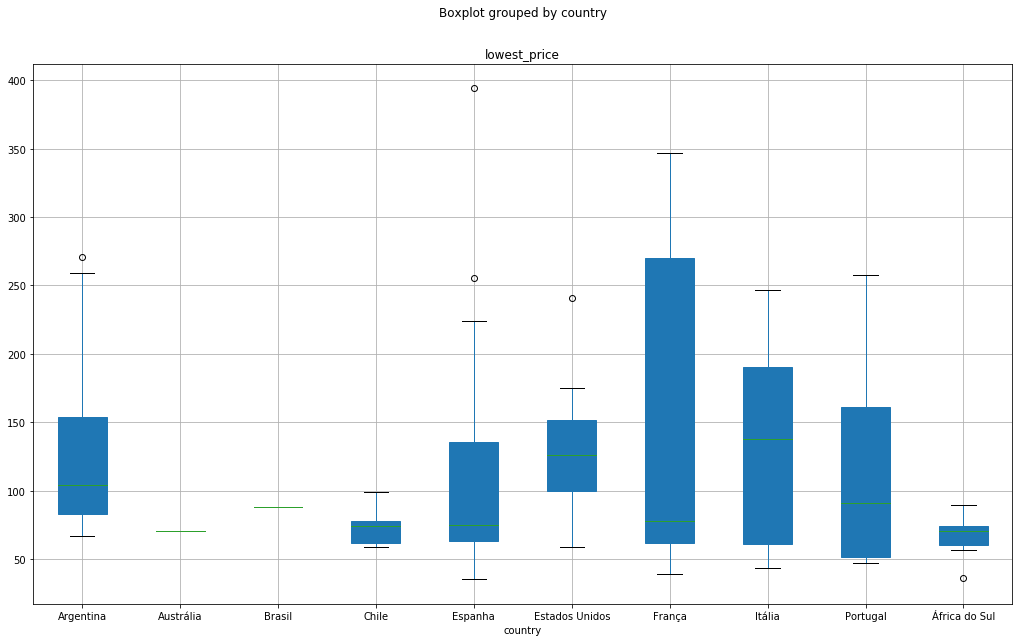

In [29]:
### Referencia: wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

plot_df = work_df.loc[(work_df.lowest_price <= 400.0) & (work_df.vivino_rating >= work_df.vivino_rating.median())]
plot_df.boxplot(by='country',column=['lowest_price'], figsize=(17,10), patch_artist=True)

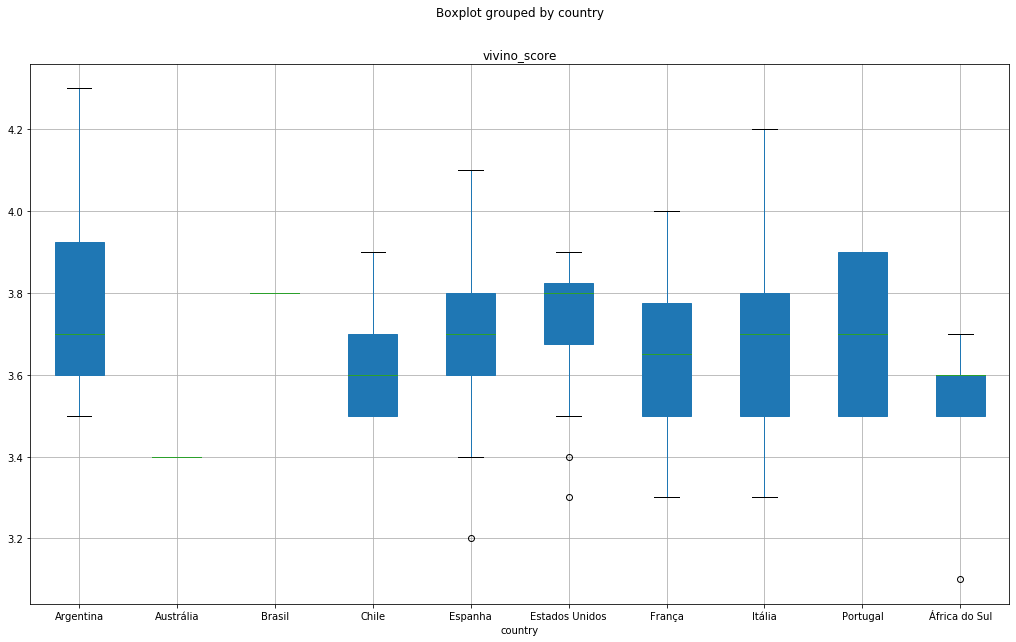

In [30]:
plot_df.boxplot(by='country',column=['vivino_score'], figsize=(17,10), patch_artist=True)

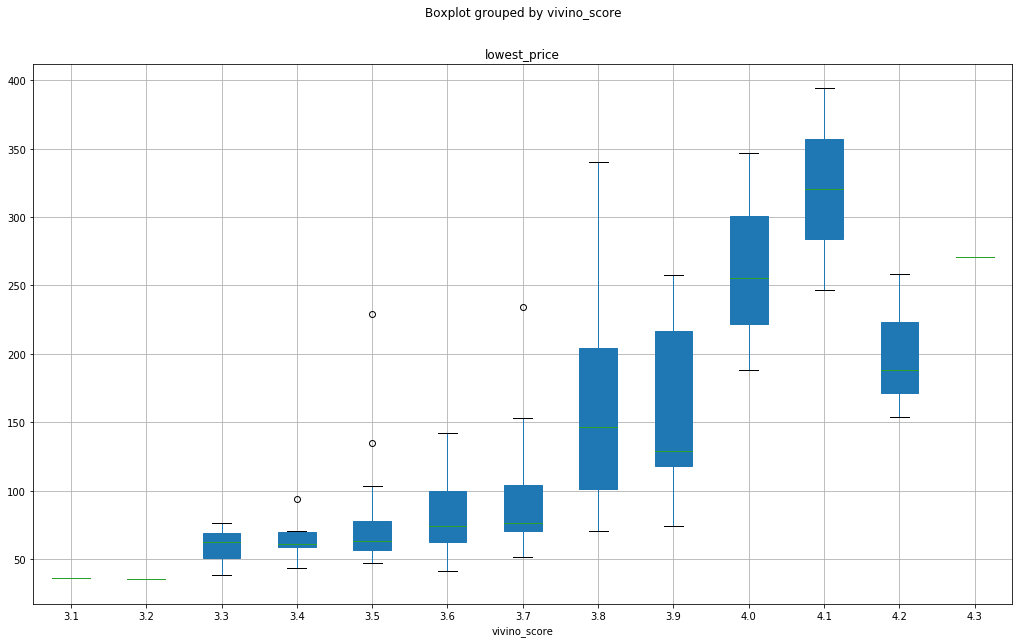

In [31]:
plot_df.boxplot(by='vivino_score',column=['lowest_price'], figsize=(17,10), patch_artist=True)

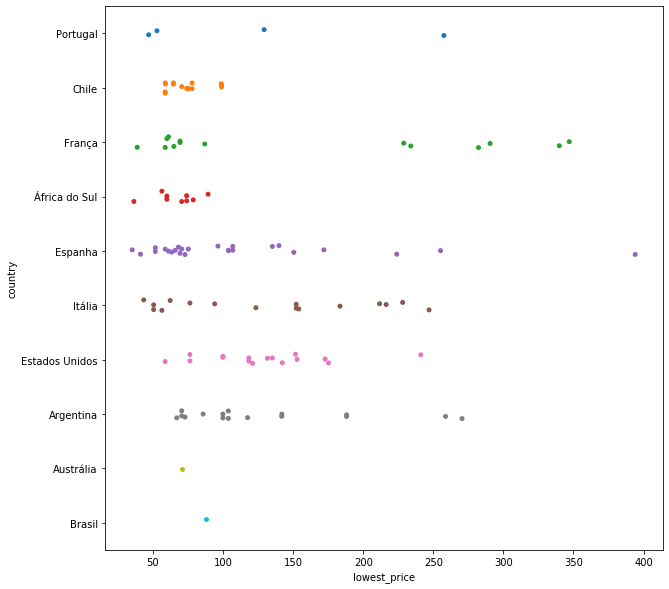

In [32]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(x="lowest_price", y="country", data=plot_df, ax=ax, jitter= True)
plt.show()

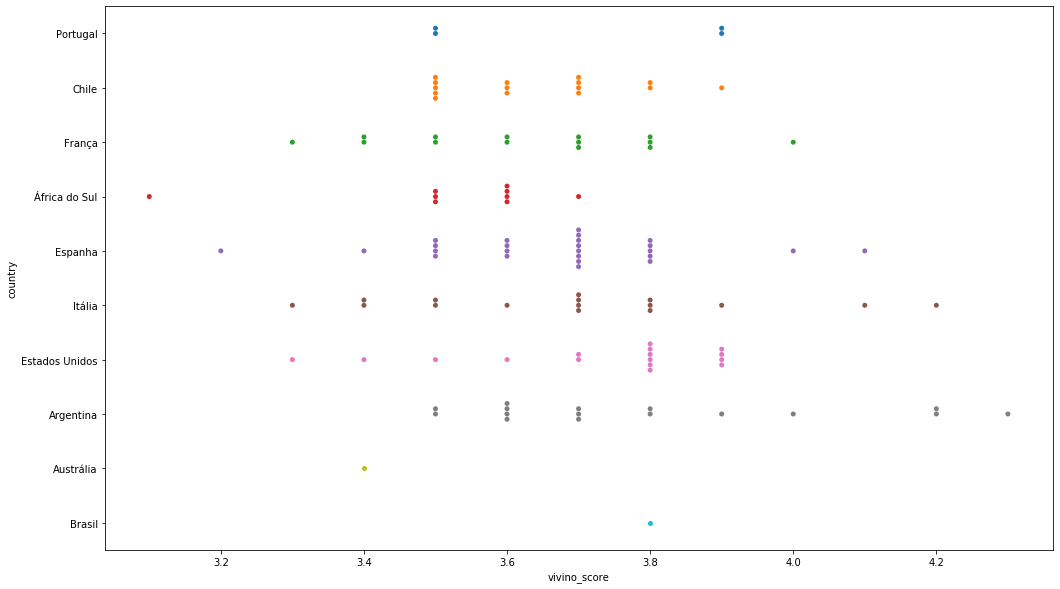

In [33]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="country", data=plot_df, ax=ax)
plt.show()

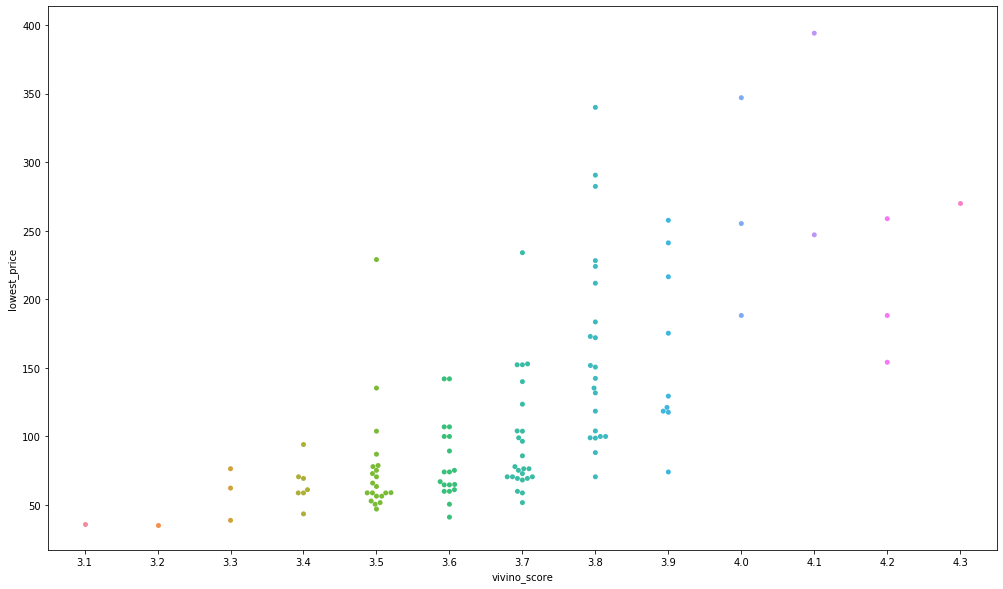

In [34]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="lowest_price", data=plot_df, ax=ax)
plt.show()

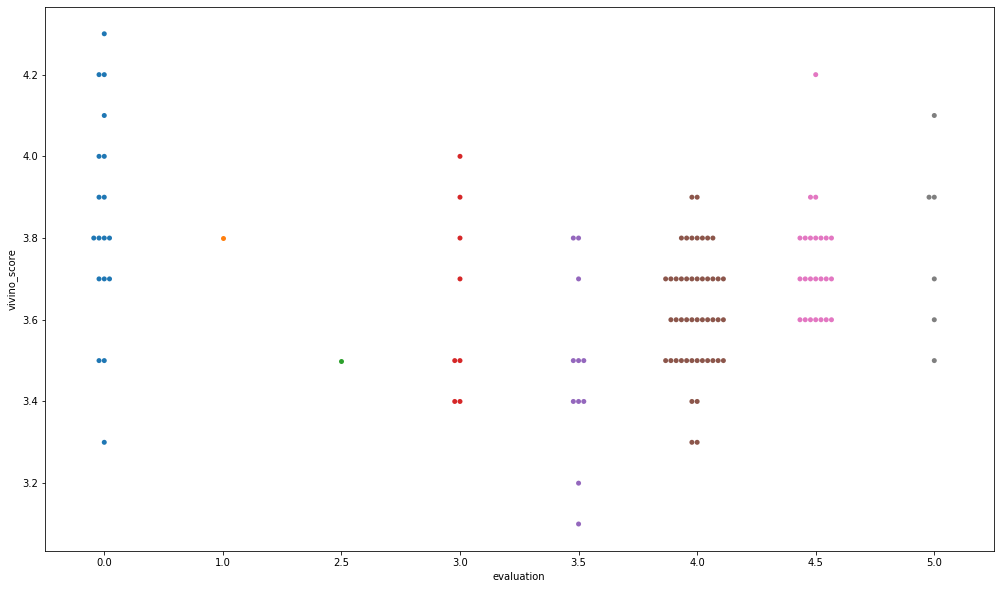

In [35]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="evaluation", y="vivino_score", data=plot_df, ax=ax)
plt.show()

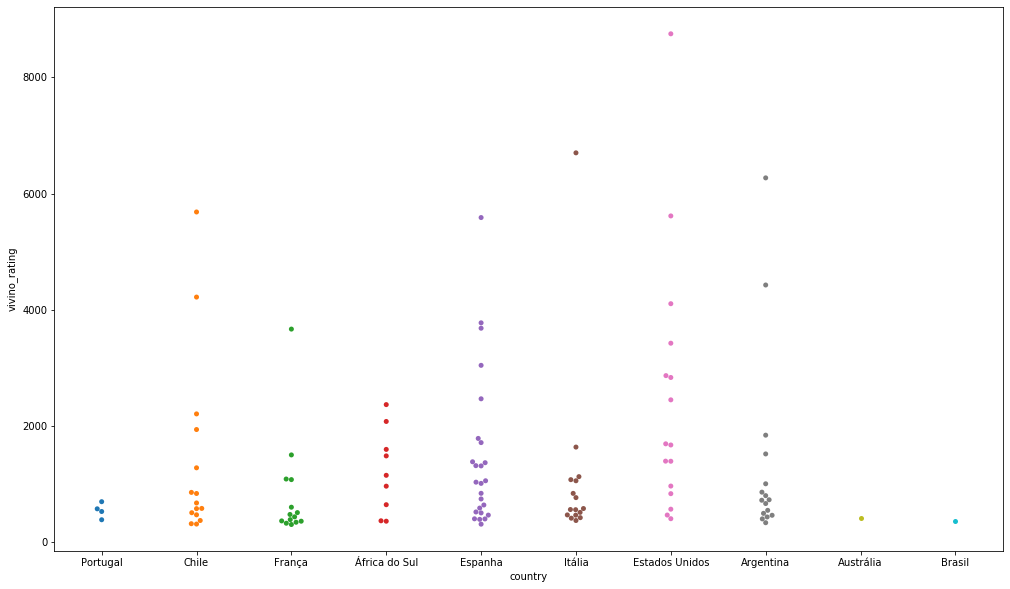

In [36]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="country", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

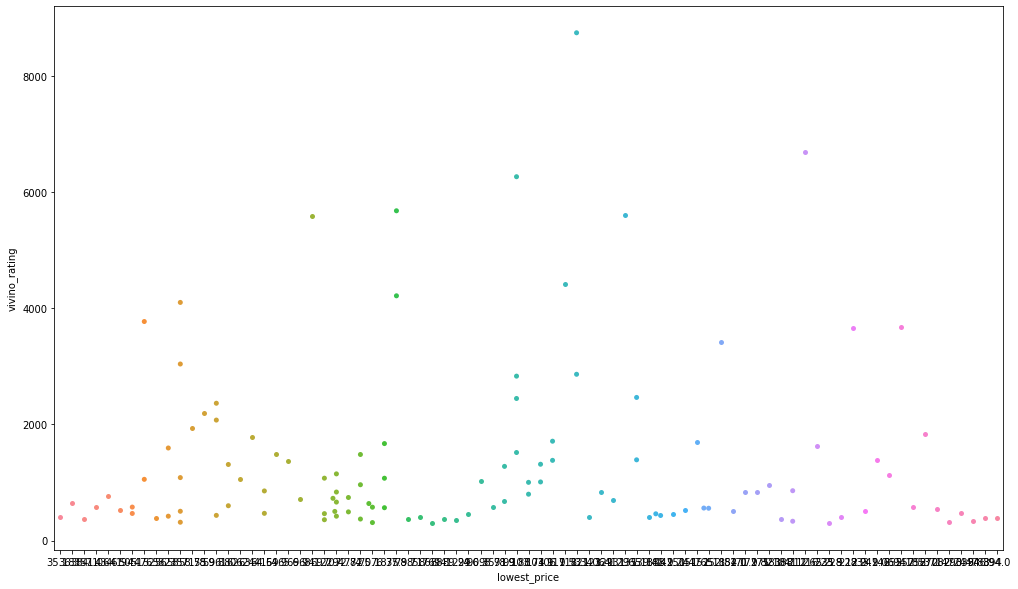

In [37]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="lowest_price", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

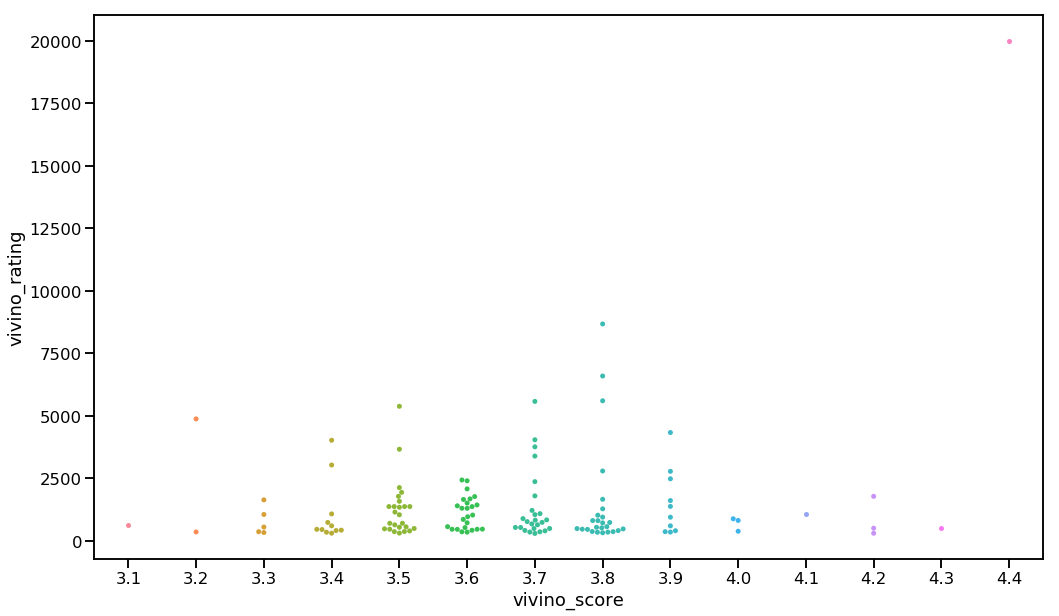

In [106]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

In [38]:
menor_preco = work_df.groupby(['country','vivino_score']).apply(lambda df: df.loc[df.lowest_price.idxmin()])
display(menor_preco)

Unnamed: 0  \
country       vivino_score               
Alemanha      3.6                  222   
              4.0                    2   
Argentina     3.4                  294   
              3.5                  292   
              3.6                    3   
...                                ...   
África do Sul 3.5                   42   
              3.6                  181   
              3.7                  179   
              4.0                   74   
              4.2                  227   

                                                                    wine_name  \
country       vivino_score                                                      
Alemanha      3.6           Ernst Loosen Winemakers Select Pfalz Edition P...   
              4.0                  Ernst Loosen Pfalz Edition Dornfelder 2018   
Argentina     3.4                                 Que Guapo Malbec Blend 2018   
              3.5                                Partridge Flying Malbec 2019   
              3.6                   Partridge Reserva Cabernet Sauvignon 2018   
...                                                                       ...   
África do Sul 3.5                          Tormentoso Cabernet Sauvignon 2016   
              3.6                  Lievland Vineyards Cabernet Sauvignon 2017   
              3.7                  Lievland Vineyards Bush Vine Pinotage 2017   
              4.0                                   Fleur Du Cap Laszlo 2015.   
              4.2                                       Marianne Floreal 2015   

                                                                         link  \
country       vivino_score                                                      
Alemanha      3.6           wine.com.br/vinhos/ernst-loosen-winemakers-sel...   
              4.0           wine.com.br/vinhos/ernst-loosen-pfalz-edition-...   
Argentina     3.4           wine.com.br/vinhos/que-guapo-malbec-blend-2018...   
              3.5           wine.com.br/vinhos/partridge-flying-malbec-201...   
              3.6           wine.com.br/vinhos/partridge-reserva-cabernet-...   
...                                                                       ...   
África do Sul 3.5           wine.com.br/vinhos/tormentoso-cabernet-sauvign...   
              3.6           wine.com.br/vinhos/lievland-vineyards-cabernet...   
              3.7           wine.com.br/vinhos/lievland-vineyards-bush-vin...   
              4.0           wine.com.br/vinhos/fleur-du-cap-laszlo-2015-/p...   
              4.2           wine.com.br/vinhos/marianne-floreal-2015/prod1...   

                                  country   type  \
country       vivino_score                         
Alemanha      3.6                Alemanha  tinto   
              4.0                Alemanha  tinto   
Argentina     3.4               Argentina  tinto   
              3.5               Argentina  tinto   
              3.6               Argentina  tinto   
...                                   ...    ...   
África do Sul 3.5           África do Sul  tinto   
              3.6           África do Sul  tinto   
              3.7           África do Sul  tinto   
              4.0           África do Sul  tinto   
              4.2           África do Sul  tinto   

                                                                  description  \
country       vivino_score                                                      
Alemanha      3.6                      Leve, acidez presente, taninos sedosos   
              4.0             Frutado, leve, acidez agradável, taninos macios   
Argentina     3.4           Frutado, médio corpo, taninos macios, fresco, ...   
              3.5           Corpo de leve para médio, frutado, acidez agra...   
              3.6           Frutado, médio corpo, acidez agradável, tanino...   
...                                                                       ...   
África do Sul 3.5           Médio corpo, taninos